<div class="alert alert-block alert-info">
<b>Notice:</b> This companion notebook showcases the main features implemented in this repository and unravels code from other python files.
   
It illustrates: <li> the <a href=#train_py>training</a> of  GRSSL models,</li><li>how to assess models' <a href=#classification>classification capabilities</a></li><li> and possible <a href=#visualisation>visualisations of the embeddings</a></li>
</div>

In [1]:
from train import *

from Utils.tasks import *

%load_ext autoreload
%autoreload 2

In [2]:
#### check torch is using GPU:
print("torch.cuda.is_available(): {}".format(torch.cuda.is_available()))
print("torch.cuda.device_count(): {}".format(torch.cuda.device_count()))
if torch.cuda.is_available():
    print("torch.cuda.current_device(): {}".format(torch.cuda.current_device()))
    print("torch.cuda.device(0): {}".format(torch.cuda.device(0)))
    print("torch.cuda.get_device_name(0): {}".format(torch.cuda.get_device_name(0)))

torch.cuda.is_available(): False
torch.cuda.device_count(): 0


In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



**Table of Content:**

0. [Parse the configuration file](#parsing)
1. [Trainig GRSSL model](#train_py)
    1. [🧳 Data](#data)
    1. [🌻 Model](#model)
    5. [⚙️ Trainer](#trainer)
2. [Assess classification capabilities](#classification)
    1. [🟢 Netzschleuder dataset (from training)](#classification_netzschleuder)
    8. [🟣 TUDataset (conventional)](#classification_tudataset)
3. [Visualisation of the embeddings](#visualisation)
    
TODO:
- [x] visualising embeddings
- [ ] other assessment tasks

## 0. Parse Config file <a class="anchor" id="parsing"></a>

Fill the path to the `.json` configuration file of the model to be trained below. The configuration will be loaded and parsed. The arguments will serve to initialise the DataLoader, Model and Trainer afterward.

In [4]:
CONFIG_PATH = "Configs/config_files/config_pgcl_show.json"

config = ConfigParser.from_json(json_path = CONFIG_PATH)

---

# Training GRSSL model <a class="anchor" id="train_py"></a>

This section shows the process going on in `main` method from [`train.py`](./train.py).

## A. 🧳 Data <a class="anchor" id="data"></a>

First, the data are loaded. If a `.csv` with references to Netzschleuder instances is given, the graphs are loaded from the `graph-tool` library and converted in `DGL` format to be further processed using deep learning libraries. Otherwise native datasets from `DGL`, such as the TUDatasets, can directly be given to the model and loaded as the training data.

### a) Load Dataset: `GraphDataset`

In [5]:
dataset = config.init_obj('dataset', module_dataset)

🦦 converting 4489 graphs from graph-tool library to DGL format.


100%|█████████████████████████████| 4489/4489 [16:34<00:00,  4.51it/s, graph=yeast_transcription]

The following graphs:
'['budapest_connectome/all_20k', 'budapest_connectome/female_20k', 'budapest_connectome/male_20k', 'budapest_connectome/male_200k', 'budapest_connectome/male_1m', 'dutch_criticism', 'gnutella/4', 'gnutella/6', 'gnutella/8', 'gnutella/9', 'hiv_transmission']'
... could not have been loaded from graph-tool library.


In [6]:
print(dataset)

┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                   6|
|   - 0 (Biological)                    |       1495 (3

### b) Build data loader (`GraphDataLoader`)

The data loader is instanciated from the graphs dataset. It will pass batches of data to the model during training.

In [7]:
data_loader = dataset.make_GraphDataLoader(config["data_loader"])

In [8]:
valid_data_loader = None # no validation here

## B. 🌻 Model <a class="anchor" id="model"></a>

Then, it is the turn of the model to be instantiated. Based on the arguments parsed from the configuration file, the given model is initialised, ready to be trained.

In [9]:
model = config.init_obj('arch', module_arch)

In [10]:
# prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

In [11]:
print(model)

PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (3): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, aff

## C. ⚙️ Trainer <a class="anchor" id="trainer"></a>

Finally, the trainer itself comes into play. It is characterized by the various hyperparameters that come into play during the training phase, such as the learning rate, the choice of the loss metric, or the number of epochs, but also model specific arguments.

In [12]:
criterion = config.init_obj('loss_type', module_loss)

In [13]:
metrics = None#[getattr(module_metric, met) for met in config['metrics']]

In [14]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)

In [15]:
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

In [16]:
# 3.1 build trainer 
trainer_type = getattr(module_train, config['trainer_type']["type"])
trainer = trainer_type(model,
                       criterion,
                       metrics,
                       optimizer,
                       config=config,
                       device=device,
                       data_loader=data_loader,
                       valid_data_loader=valid_data_loader,
                       lr_scheduler=lr_scheduler,
                       **config['trainer_type']['args']
                      )

Everything is initialised by now, let's train the model for real! 

> **Warning**
> Depending on the model's architecture, the size of the training dataset, the number of epochs and other variables this phase could take some time. 
(It should last about 20 minutes for the default showcase configuration but lasted more than 7 hours per model in average when training the final PGCL models.)

In [17]:
%%capture --no-stdout --no-display 
# capture warnings for readibility of the output
# 3.2 🧞 train the model
training_time = time()
trainer.train()
training_time = time() - training_time

Saving checkpoint: saved/show/models/PGCL/0321_002939/model_untrained.pth ...
Train Epoch: 1 [0/35 (0%)] Loss: 23.568857
Train Epoch: 1 [11/35 (31%)] Loss: 23.041298
Train Epoch: 1 [22/35 (63%)] Loss: 23.451483
Train Epoch: 1 [33/35 (94%)] Loss: 22.508528
    epoch          : 1
    loss           : 23.190621839250838
    time           : 00:05:00
    no improvement : 0
Saving current best: model_best.pth ...
Train Epoch: 2 [0/35 (0%)] Loss: 22.810719
Train Epoch: 2 [11/35 (31%)] Loss: 22.755043
Train Epoch: 2 [22/35 (63%)] Loss: 23.185251
Train Epoch: 2 [33/35 (94%)] Loss: 22.192009
    epoch          : 2
    loss           : 22.76174785069057
    time           : 00:04:54
    no improvement : 0
Saving current best: model_best.pth ...
Train Epoch: 3 [0/35 (0%)] Loss: 22.846218
Train Epoch: 3 [11/35 (31%)] Loss: 22.428501
Train Epoch: 3 [22/35 (63%)] Loss: 23.070908
Train Epoch: 3 [33/35 (94%)] Loss: 22.126015
    epoch          : 3
    loss           : 22.57945485796247
    time       

In [18]:
print("It took {} to train the model.".format(seconds2hms(training_time)))

It took 00:20:17 to train the model.


If you want to modify the initial configuration, or train a whole new model, you can go back to [parsing ⬆️](#parsing).

Otherwise, let's evaluate the performances of our trained model.

---

# Assess classification capabilities <a class="anchor" id="classification"></a>

Now that we have trained a model for graph classification, it is time to evaluate its performances. To do so, we'll rely on the task of graphs classification.

First, we'll see if the model manages to classify correctly the [data it was trained on](#classification_netzschleuder). Then, we'll evaluate its performances on a [popular dataset](#classification_tudataset) commonly used in GRL literature to benchmark the models.

The evaluation procedure is encapsulated into a function that will load the model, the dataset, perform an N-fold SVC classification and report the average accuracy obtained.

In [19]:
from Utils.tasks import *

## 🟢 Netzschleuder dataset (from training) <a class="anchor" id="classification_netzschleuder"></a>

In [20]:
%%time

test_classification = testmodel_dataset(
    model=trainer,
    dataset=None, # --> loaded from trainer
    logger=None, # --> loaded from trainer
    seed=0, # --> seed of the experiment
    n_repeat=10, # --> N-fold
    dummy_baselines=["most_frequent","uniform"], # --> dummy baselines
)

PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (3): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, aff

## 🟣 TUDataset (standard) <a class="anchor" id="classification_tudataset"></a>

The TUDatasets host several graphs dataset commonly used to benchmark GRL models on graph classification tasks. Let's consider one of these dataset here: `REDDIT-BINARY`.

In [21]:
%%time

test_classification_rdb = testmodel_dataset(
    model=trainer,
    dataset="REDDIT-BINARY", # --> loaded from trainer
    logger=None, # --> loaded from trainer
    seed=0,
    n_repeat=10,
    dummy_baselines=["most_frequent","uniform"],
)

PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (3): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, aff

/Users/nmm/Desktop/GRbNSR/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:01.
10-folds SVC-Classification from embeddings ...
	... classification computed in: 00:00:44.
Computing dummy predictions: ['most_frequent', 'uniform'].
Scores:
	- Micro-F1 = 0.915
	- Micro-F1 (std.) = 0.01265
	- most_frequent - micro-F1 = 0.5
	- most_frequent - micro-F1 (std.) = 0
	- uniform - micro-F1 = 0.51
	- uniform - micro-F1 (std.) = 0.02748
CPU times: user 16.4 s, sys: 558 ms, total: 17 s
Wall time: 48.1 s


---
# Visualisation of the embeddings  <a class="anchor" id="visualisation"></a>

This section demonstrates the visualisation that can be plotted using the script implemented in [`viz.py`](./viz.py).

The graphs representations are mapped to two dimensions in order to enable their visualisation and the exploration of the spaces induced by the GRL models.

The different steps are encapsulated in a function that can directly be called to generate the visualisation of a dataset according to a model

In [22]:
import viz as viz

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (3): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, aff

/Users/nmm/Desktop/GRbNSR/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:10.
📽 Initialising the Graph Representation Visualiser
projecting embeddings with TSNE.


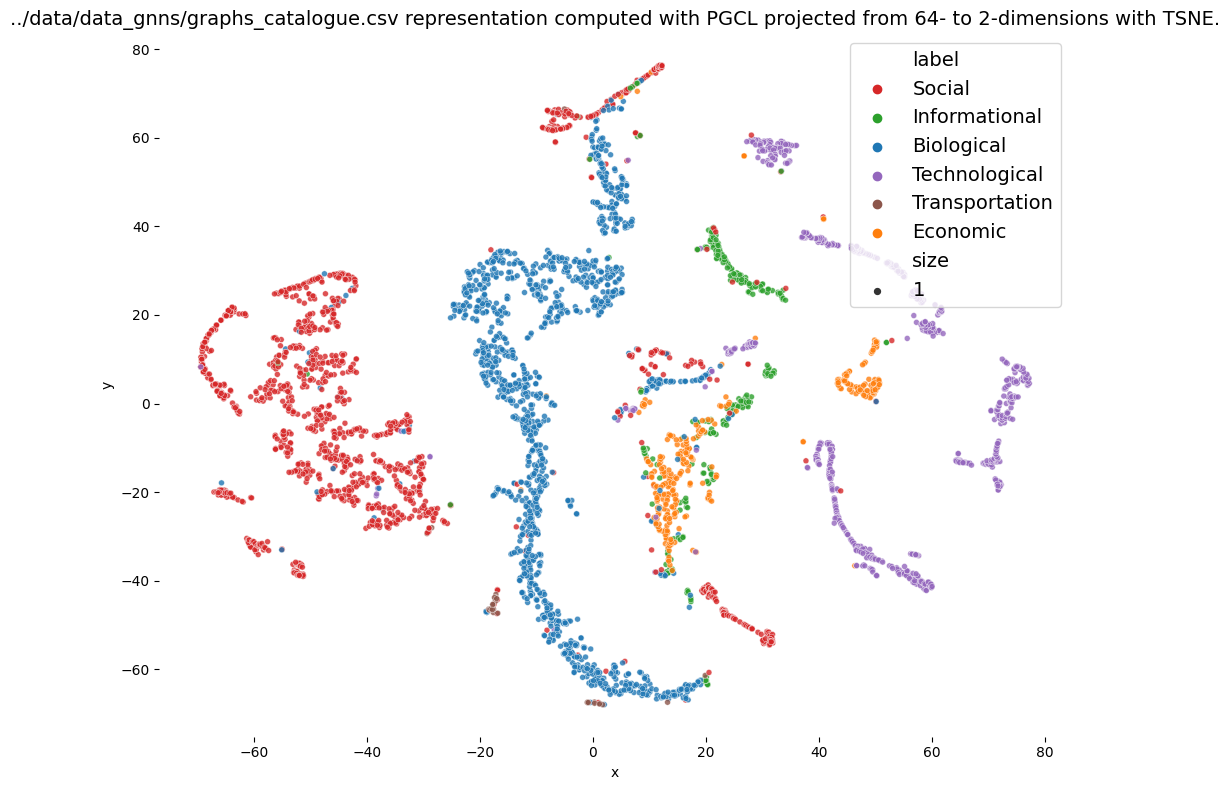

Dash app running on http://0.0.0.0:8060/


In [23]:
viz.main(
    model=trainer, # --> retrive model to generate representations
    model_name=trainer.config["name"], # --> name to title the figures
    red_type="manifold.TSNE", # --> reduce from dimension D to 2 dimensions
    no_interactive=False, # --> open the port hosting the interactive visualisation; link printed below figure
)

PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
      (3): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, aff

/Users/nmm/Desktop/GRbNSR/DL_module/Models/model_util.py:151: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



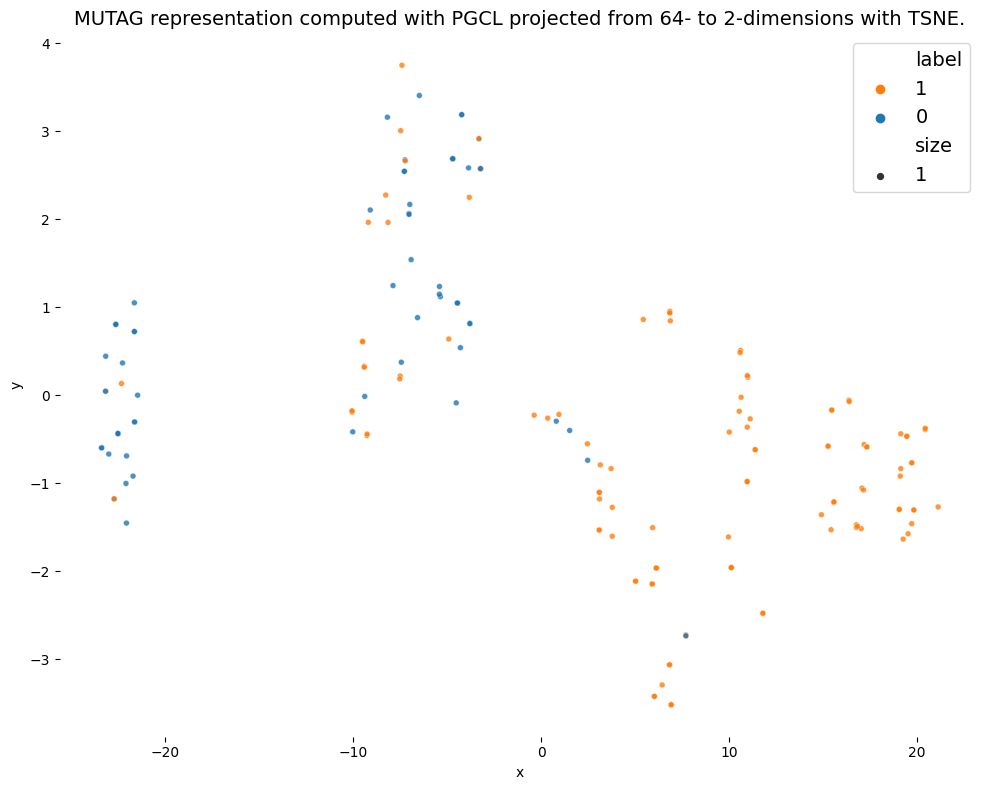

Dash app running on http://0.0.0.0:8060/


In [24]:
viz.main(
    model=trainer,
    dataset="MUTAG",
    model_name=trainer.config["name"],
    red_type="manifold.TSNE",
    no_interactive=False,
)

In [ ]:
url

In [ ]:
req = Request(url, method="POST")
res = urlopen(req)
content = res.read()
print(content)

In [ ]:
from flask import socketio2

In [ ]:
from flask import request

request.environ.get('werkzeug.server.shutdown')

In [ ]:
import multiprocessing
import multiprocess as mp

In [ ]:
def mp_run_server(**kwargs):
    app.run_server(**kwargs)
    return 

In [ ]:
p = mp.Process(target=mp_run_server,#app.run_server,
               name="Foo",
               kwargs={
                   "debug":True,
                   "mode":"external",
                   "port":"8060",
                   "host":"localhost",#"127.0.0.1"
               }
              )
#p.start()

In [ ]:
p.start()

In [ ]:
p.terminate()
p.join()

In [ ]:
shutdown_url = "http://{host}:{port}/_shutdown_{token}".format(
    host="127.0.0.1", port="8060", token=viz.module_viz.Dash._token
)

```python
@classmethod
    def _terminate_server_for_port(cls, host, port):
        shutdown_url = "http://{host}:{port}/_shutdown_{token}".format(
            host=host, port=port, token=JupyterDash._token
        )
        try:
            response = requests.get(shutdown_url)
        except Exception as e:
            pass
```

In [ ]:
shutdown_url = "http://{host}:{port}/_shutdown_{token}".format(
    host="localhost", port="8060", token=viz.module_viz.Dash._token
)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
import pandas as pd

from matplotlib import cm
import seaborn as sns

In [ ]:
def scatter_embedding_visualizer(df:pd.DataFrame
                                 , x_col: str
                                 , y_col: str
                                 , size_attr: str
                                 , color_attr: str=None
                                 , cmap: str='viridis'
                                 , fig_dimensions:tuple = (25,15)
                                 , cat2color: dict=None
                                 , color_list: list=cm.get_cmap("tab10").colors
                                 , categorical_color:bool = False
                                ):

    categorical_color = type(df[color_attr][0])==str
    
    fig, ax = plt.subplots(figsize=fig_dimensions)
    
    if not categorical_color:
        plot = sns.scatterplot(
            x=df[x_col],
            y=df[y_col],
            hue=df[color_attr],
            palette=cm.get_cmap(cmap),
            size=df[size_attr],
            alpha=0.4,
        )
        
        # add colorbar
        norm = plt.Normalize(df[color_attr].min(), df[color_attr].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        fig.colorbar(sm).outline.set_visible(False)
        
    else:
        
        if cat2color==None: 
            discrete_cats = sorted(df[color_attr].unique())
            cat2color= dict(zip(discrete_cats, color_list[:len(discrete_cats)]))
            
        plot = sns.scatterplot(
            x=df[x_col],
            y=df[y_col],
            hue=df[color_attr],
            palette=cat2color,
            size=df[size_attr],
            alpha=0.8,
        )
        
    # remove frame
    sns.despine(bottom = True, left = True)

    plot.legend(fontsize=14)
    plt.tight_layout()
    # show plot
    plt.show()
    
    return

In [ ]:
emb = TSNE(2)
#emb = PCA(2)
#emb = MDS(2, metric=False)

In [ ]:
#emb2d = emb.fit_transform(test_classification.embeddings)
emb2d = emb.fit_transform(test_classification_tu.embeddings)

In [ ]:
embx = [e[0] for e in emb2d]
emby = [e[1] for e in emb2d]

In [ ]:
embs = pd.DataFrame([embx, emby], ["x", "y"]).T
embs["size"] = 1
#embs["label"] = [dataset.labId_to_labName[lab] for lab in test_classification.labels]
embs["label"] = [str(lab) for lab in test_classification_tu.labels]

In [ ]:
scatter_embedding_visualizer(df=embs
                             , x_col="x"
                             , y_col="y"
                             , size_attr="size"
                             , color_attr="label"
                             #, cmap: str='viridis'
                             , fig_dimensions = (12, 12)
                             #, cat2color:=None
                             , color_list=list(cm.get_cmap("tab10").colors)
                             , categorical_color = True
                            )

In [ ]:
tu_data = TUDataset("REDDIT-BINARY")

tu_graphs = tu_data.graph_lists
tu_labels = [int(lab[0]) for lab in tu_data.graph_labels]

In [ ]:
tu_dataset = module_dataset.GraphDataset(dgl_graphs = tu_graphs, graphs_labels = tu_labels)

In [ ]:
dummy_dim = 32

dummy_embs = np.array([np.random.random(dummy_dim) for _ in range(len(tu_dataset))])

In [ ]:
%%time
model.eval()
model_embs = np.array([model.embed(g) for g in tu_dataset])
model_embs = torch.cat([emb.detach().cpu() for emb in model_embs])

In [ ]:
shuffled_ids = [i for i, _ in enumerate(tu_dataset)]
np.random.shuffle(shuffled_ids)

In [ ]:
shuffled_graphs = [tu_graphs[idx] for idx in shuffled_ids]
shuffled_labels = [tu_labels[idx] for idx in shuffled_ids]
shuffled_dataset = module_dataset.GraphDataset(dgl_graphs = shuffled_graphs, graphs_labels = shuffled_labels)

shuffled_embs = model_embs[shuffled_ids]# for idx in shuffled_ids]

In [ ]:
checks_classification = GraphClassification(
    #dataset = tu_dataset,
    dataset = shuffled_dataset,
    #provided_embeddings = model_embs#dummy_embs
    provided_embeddings = shuffled_embs
)

In [ ]:
checks_classification.classification_scores()

In [ ]:
checks_classification.get_dummy_preds()

In [ ]:
checks_classification.print_scores()

In [ ]:
from Models import model_grssl
from DataLoader import data_loader
from DataLoader.data_util import *

from Trainers import trainer

%load_ext autoreload
%autoreload 2

In [ ]:
import DataLoader.data_loader as module_dataset
import Models.model_grssl as module_arch
import Trainers.loss as module_loss
import Trainers.trainer as module_train

from Utils.misc import prepare_device

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

from dgl.dataloading import GraphDataLoader

In [ ]:
from Configs.configs_parser import *
import argparse

import collections

In [ ]:
CONFIG_PATH = "Configs/config.json"

config = ConfigParser.from_json(json_path=CONFIG_PATH)

logger = config.get_logger('train')
logger.info("Config loaded from: '{}'.".format(CONFIG_PATH))

# load dataset and setup data_loader instances
logger.info("🌐 Loading Dataset...")
dataset = config.init_obj('dataset', module_dataset)
logger.info("Dataset loaded:\n{}".format(dataset))

data_loader = GraphDataLoader(
    dataset=dataset,
    **config["data_loader"]
)
valid_data_loader = None#data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info("🤖 Model instantiated:{name} ({l})\n{m}".format(name=model.model_name
                                                             , l=model.model_type
                                                             , m=model
                                                            )
           )

# prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# get function handles of loss and metrics
#criterion = getattr(module_loss, config['loss'])
criterion = config.init_obj('loss_type', module_loss)
metrics = None#[getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

In [ ]:
# get Trainer and build it
trainer_type = getattr(module_train, config['trainer_type']["type"])

In [ ]:
trainer = trainer_type(model,
                       criterion,
                       metrics,
                       optimizer,
                       config=config,
                       device=device,
                       data_loader=data_loader,
                       valid_data_loader=valid_data_loader,
                       lr_scheduler=lr_scheduler,
                       **config['trainer_type']['args']
                      )

In [ ]:
trainer.train()

## 🔀 GCC

In [ ]:
pretext_keys = ["ceo_club", "bison", "copenhagen/calls"]
fake_labels = ["label2", "label1", "label2"]

### DataLoader

In [ ]:
test_gcc = data_loader.GCCDataset(dgl_graphs=graphtoolkeys2dglgraphs(pretext_keys)
                                  , graphs_labels=fake_labels
                                  , verbosity=True
                                 )

In [ ]:
test_gcc[0]

### Load config

In [ ]:
config = ConfigParser.from_json(json_path="Configs/config_gcc.json")

logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
#valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# get function handles of loss and metrics
#criterion = getattr(module_loss, config['loss'])
#metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

In [ ]:
def batcher():
    def batcher_dev(batch):
        graph_q, graph_k = zip(*batch)
        graph_q, graph_k = dgl.batch(graph_q), dgl.batch(graph_k)
        return graph_q, graph_k

    return batcher_dev

def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset
    dataset.graphs, _ = dgl.data.utils.load_graphs(
        dataset.dgl_graphs_file, dataset.jobs[worker_id]
    )
    dataset.length = sum([g.number_of_nodes() for g in dataset.graphs])
    np.random.seed(worker_info.seed % (2 ** 32))
    
gcc_graph_loader = GraphDataLoader(
     dataset=config["data_loader"],#gtdata,
    batch_size=16,
    collate_fn=labeled_batcher() if False else batcher(),
    shuffle=True if False else False,
    num_workers=0,
    worker_init_fn=None if False or False else worker_init_fn,
)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=config["data_loader"],#gtdata,
    batch_size=16,
    collate_fn=labeled_batcher() if False else batcher(),
    shuffle=True if False else False,
    num_workers=0,
    worker_init_fn=None if False or False else worker_init_fn,
)

In [ ]:
gcc_trainer = trainer.GCCTrainer(
    model=graphmae_model,
    criterion=None,
    metric_ftns=None,
    optimizer=optimizer,
    config= config,#{"trainer":{"epochs":2,
                  #      "save_period":1,
                  #      "monitor":"min",
                  #     }
            #},
    device='cpu',
    data_loader=gcc_graph_loader, #  XXX
    valid_data_loader=None,
    lr_scheduler=None,
    len_epoch=None,
    alpha_moco=0.01,
)

In [ ]:
gcc_trainer.train()

### Model

In [ ]:
gin_args = {
    'num_layers':4,
    'input_dimension':65,
    'output_dimension':16,
    'hidden_dimension':64
}

In [ ]:
gcc_model = model_grssl.GCCModel(encoder_args=gin_args, norm=True)

In [ ]:
gcc_model.degree_input

In [ ]:
test_gcc.graphs

In [ ]:
gcc_model.encoder.input_dimension

In [ ]:
gcc_model(test_gcc[0][0]).shape

### Trainer

## 🎭 GraphMAE

### DataLoader

In [ ]:
pretext_keys = ["ceo_club", "bison", "copenhagen/calls"]
fake_labels = ["label2", "label1", "label2"]

test_mae = data_loader.GraphMAEDataset(pretext_keys#dgl_graphs=graphtoolkeys2dglgraphs(pretext_keys)
                                  , graphs_labels=fake_labels
                                  , verbosity=True
                                 )

In [ ]:
batch_size=32

train_idx = torch.arange(len(test_mae))
train_sampler = SubsetRandomSampler(train_idx)

test_train_loader = GraphDataLoader(test_mae
                                    #, sampler=train_sampler
                                    #, collate_fn=collate_fn
                                    , batch_size=batch_size
                                    , pin_memory=True
                                   )

In [ ]:
test_mae[0][0].ndata["attr"].shape

### Model

In [ ]:
gin_args = {
    'num_layers':4,
    'input_dimension':22,
    'output_dimension':16,
    'hidden_dimension':64
}

graphmae_model = model_grssl.GraphMAEModel(encoder_args=gin_args, drop_rate=0.01)

In [ ]:
graphmae_model(test_mae[0][0], test_mae[0][0].ndata["attr"])

In [ ]:
graphmae_model.encoder_to_decoder

In [ ]:
test_mae[0][0]

### Load Config

In [ ]:
from Configs.configs_parser import *
import argparse

import collections

In [ ]:
config = ConfigParser.from_json(json_path="Configs/config.json")

logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
#valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# get function handles of loss and metrics
#criterion = getattr(module_loss, config['loss'])
#metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

### Trainer

In [ ]:
config["optimizer"]

In [ ]:
mae_trainer = trainer.GraphMAETrainer(
    model=graphmae_model,
    criterion=None,
    metric_ftns=None,
    optimizer=optimizer,
    config= config,#{"trainer":{"epochs":2,
                  #      "save_period":1,
                  #      "monitor":"min",
                  #     }
            #},
    device='cpu',
    data_loader=test_train_loader,
    valid_data_loader=None,
    lr_scheduler=None,
    len_epoch=None,
)

In [ ]:
mae_trainer.train()